<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [ ]:
!pip install pytorch_lightning

In [2]:
!nvidia-smi

Mon Nov 15 20:41:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import numpy as np

import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.autograd import Variable
from typing import Tuple

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
sys.path.append('/content/drive/MyDrive/HSE/DUL')

In [4]:
from drive.MyDrive.HSE.DUL.utils.hw1_utils import *
DRIVE_DATA_PATH = 'drive/MyDrive/HSE/DUL/hw1/data/hw1_data'

In [5]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


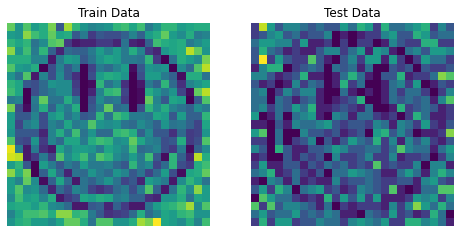

Dataset 2


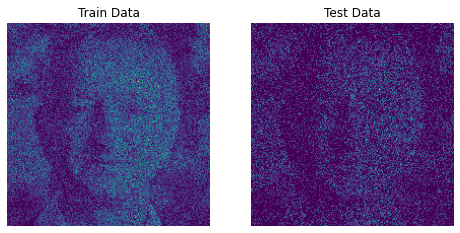

In [7]:
visualize_q1a_data(dset_type=1, data_dir=DRIVE_DATA_PATH)
visualize_q1a_data(dset_type=2, data_dir=DRIVE_DATA_PATH)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


In [5]:
class Dataset:
  def __init__(self, batch_size: int):
      self.batch_size = batch_size

  def one_hot_encoding(self, target: np.ndarray):
    return torch.nn.functional.one_hot(target)

  def stack_inputs(self, dataset: np.ndarray):
    """
      Function takes 2d array of shape n_samples x 2 and returns 
      torch tensor of shape n_samples x (n_one_hot_enc * 2).

      param:  dataset: np.ndarray

      return: torch.Tensor
    """
    x1_dim_tensor = self.one_hot_encoding(torch.Tensor(dataset[:, 0]).long()).float()
    x2_dim_tensor = self.one_hot_encoding(torch.Tensor(dataset[:, 1]).long()).float()
    return torch.cat([x1_dim_tensor, x2_dim_tensor], dim=1)

  def get_dataloader(self, dataset: np.ndarray):
    """
      param: dataset: np.ndarray

      return: torch.utils.data.dataloader.DataLoader

      Feunction takes np.ndarray of shape n_samples x 2 and return torch.loader,
      where a shape of 1 item is batch_size x d (one_hot_encoding size x 2)
    """
    dataset = self.stack_inputs(dataset)
    return torch.utils.data.DataLoader(dataset, self.batch_size, 
                                       pin_memory=True, num_workers=2,
                                       shuffle=True)


In [6]:
class MaskedLinear(nn.Linear):   
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return nn.functional.linear(input, self.mask * self.weight, self.bias)

In [7]:
class ModelSmile(nn.Module):
  def __init__(self):
    super(ModelSmile, self).__init__()
    self.layer_1 = MaskedLinear(50, 64)
    self.layer_2 = MaskedLinear(64, 64)
    self.layer_3 = MaskedLinear(64, 64)
    self.layer_4 = MaskedLinear(64, 50)

  def forward(self, x: torch.tensor):
    relu = nn.ReLU()

    x = relu(self.layer_1(x))
    x = relu(self.layer_2(x))
    x = relu(self.layer_3(x))
    x = self.layer_4(x)

    x = x.reshape(x.shape[0], 2, x.shape[1] // 2)
    return x 

class ModelGeoffrey(nn.Module):
  def __init__(self):
    super(ModelGeoffrey, self).__init__()
    self.layer_1 = MaskedLinear(400, 64)
    self.layer_2 = MaskedLinear(64, 64)
    self.layer_3 = MaskedLinear(64, 64)
    self.layer_4 = MaskedLinear(64, 400)

  def forward(self, x: torch.tensor):
    relu = nn.ReLU()

    x = relu(self.layer_1(x))
    x = relu(self.layer_2(x))
    x = relu(self.layer_3(x))
    x = self.layer_4(x)

    x = x.reshape(x.shape[0], 2, x.shape[1] // 2)
    return x 

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [10]:
class MADE(pl.LightningModule):
    def __init__(self, **kwargs):
      super().__init__()
      for key, value in kwargs.items():
        setattr(self, key, value)
      
      if self.dataset_number == 1:
        self.model = ModelSmile()  
      else:
        self.model = ModelGeoffrey()
      self.model.to(device)


      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-7)
      self.loss_function = torch.nn.CrossEntropyLoss()
      self.distribution_array = torch.zeros((self.d, self.d), dtype=torch.float32)
      self.softmax = torch.nn.Softmax(dim=-1)

      self.train_losses = []
      self.validation_losses = []
   
      self.m = {}
      self.make_masks()

    def make_masks(self):
      # first d outputs correspond to x1, second d to x2: [0..0, 1...1]
      self.m[-1] = np.repeat(np.arange(2), self.d) 

      L = len(self.hidden_size)
      for l in range(L):
        self.m[l] = np.random.randint(self.m[l - 1].min(), 1, size=self.hidden_size[l])     
      masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
      masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

      # set mask for each masked Linear layer
      layers = [l for l in self.model.modules() if isinstance(l, MaskedLinear)]
      for layer, mask in zip(layers, masks):
        layer.set_mask(mask)

    def loss(self, output, target):
      # [batch_size, 2, d] -> [batch_size, d, 2]
      output = output.transpose(1, 2)
      target_one = target[:, :self.d].max(dim=1)[1]
      target_two = target[:, self.d:].max(dim=1)[1]

      # [batch_size, 2]
      target = torch.stack([target_one, target_two], dim=1)
      loss = self.loss_function(output, target)

      return loss

    def training_step(self, x):
      logits = self.model(x)
      return self.loss(logits, x)
  
    def train_loop(self, train_data, validation_data, d=None, dset_id=None):
      """
        train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}

        test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}

        d: The number of possible discrete values for each random variable x1 and x2.
            0-24 for dataset №1, 0-199 for dataset №2

        dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

        Returns
        - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
        - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
        - a numpy array of size (d, d) of probabilities (the learned joint distribution)
      """
      dataset = Dataset(self.batch_size)
      train_loader = dataset.get_dataloader(train_data)
      validation_loader = dataset.get_dataloader(validation_data)

      for epoch in range(self.epochs):
        epoch_train_loss = []
        for x in train_loader:
          torch.cuda.empty_cache()
          loss_item = self.training_step(x.to(device))
          self.optimizer.zero_grad()
          loss_item.backward()
          self.optimizer.step()
          epoch_train_loss.append(loss_item.item())
        self.train_losses.append(np.mean(epoch_train_loss))
        
        if epoch % self.validate_each_n_epoch:
          self.validation(validation_loader)
      
      self.get_dist()
      return self.train_losses, self.validation_losses, self.distribution_array.detach().numpy()

    def validation(self, dataloader):
      with torch.set_grad_enabled(False):
        val_epoch_losses = []
        for x in dataloader:
          torch.cuda.empty_cache()
          loss_item = self.training_step(x.to(device))
          val_epoch_losses.append(loss_item.item())    
        self.validation_losses.append(np.mean(val_epoch_losses))


    def get_dist(self):
      with torch.set_grad_enabled(False):
        x1_matrix = torch.eye(self.d, dtype=torch.float32)
        x2_matrix = torch.eye(self.d, dtype=torch.float32)

        for i, x1 in enumerate(x1_matrix):
          for j, x2 in enumerate(x2_matrix):
            torch.cuda.empty_cache()
            output = self.model(torch.cat((x1, x2)).unsqueeze(0).to(device))
            probs = self.softmax(output)[0]

            self.distribution_array[i, j] = probs[0][i] * probs[1][j]


### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 3.1827


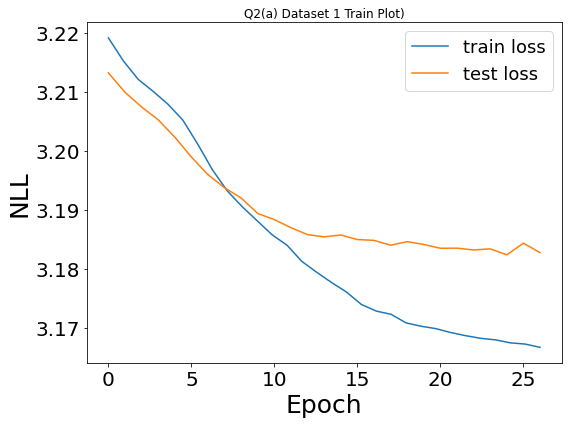

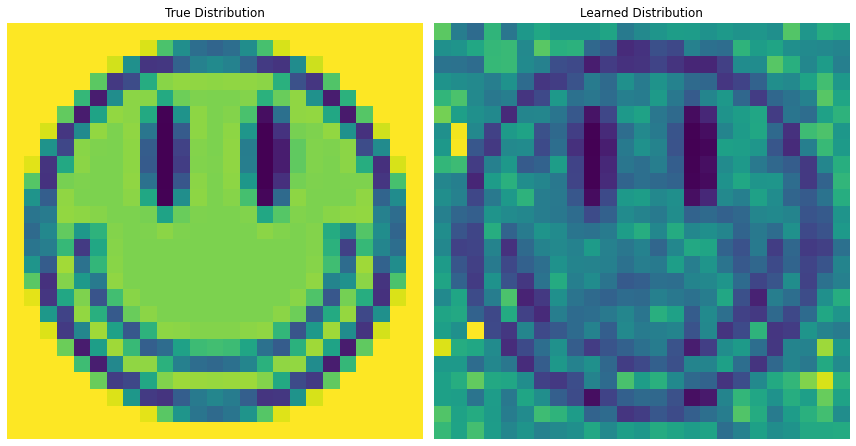

In [11]:
config_smile = {"num_layers": 5,
              "num_dim_values": 50,
              "hidden_size": [64, 64, 64],
              "batch_size": 500, 
              "epochs": 30,
              "validate_each_n_epoch": 10,
              "dataset_number": 1,
              "lr": 1e-3,
              "d": 25}
made = MADE(**config_smile)
q1_save_results(1, 'a', made.train_loop, DRIVE_DATA_PATH)

Final Test Loss: 5.2889


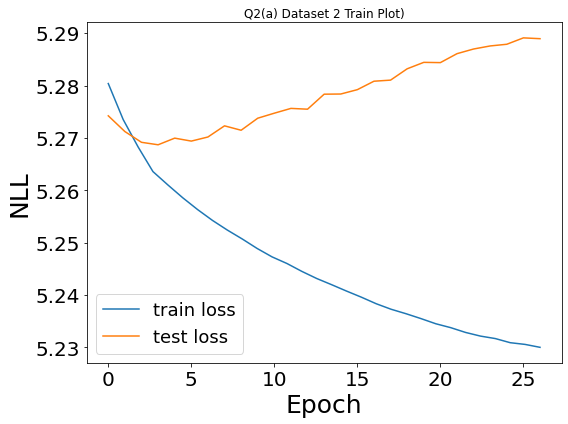

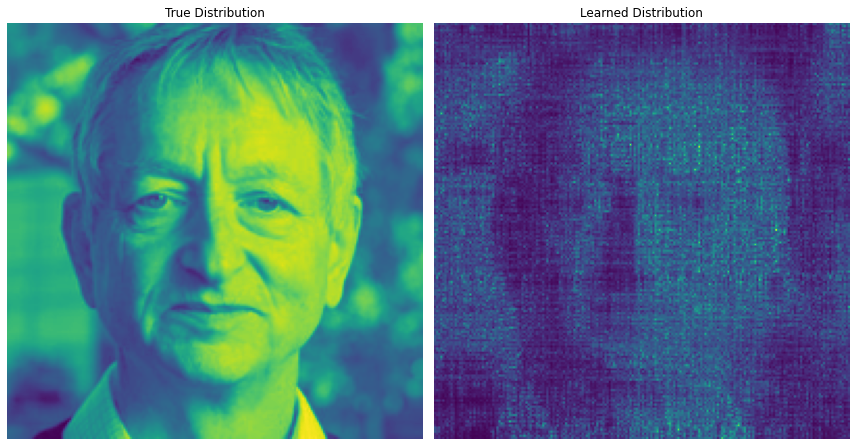

In [13]:
config_geoffrey = {"num_layers": 5,
                "num_dim_values": 400,
                "hidden_size": [64, 64, 64],
                "batch_size": 100, 
                "epochs": 30,
                "validate_each_n_epoch": 10,
                "dataset_number": 2,
                "lr": 1e-3,
                "d": 200}

made = MADE(**config_geoffrey)
q1_save_results(2, 'a', made.train_loop, DRIVE_DATA_PATH)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

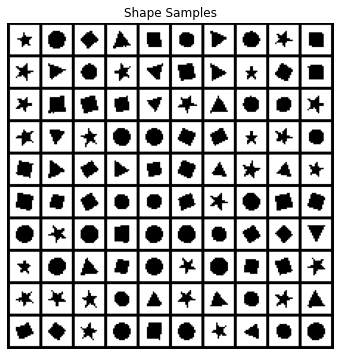

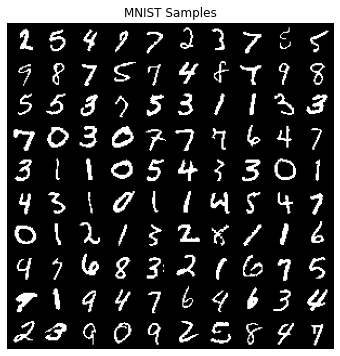

In [ ]:
visualize_q1b_data(1, data_dir=DRIVE_DATA_PATH)
visualize_q1b_data(2, data_dir=DRIVE_DATA_PATH)
# you can access data with get_data_q1_b(dset_type=1)

In [ ]:
shapes_dataset = get_data_q1_b(dset_type=1, data_dir=DRIVE_DATA_PATH)
mnist_dataset = get_data_q1_b(dset_type=2, data_dir=DRIVE_DATA_PATH)
print(shapes_dataset.shape)

(10479, 20, 20, 1)


Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
class PictureDataset:
  def __init__(self, batch_size: int):
      self.batch_size = batch_size

  def stack_inputs(self, dataset: np.ndarray):
    """
      Function takes 4d array of shape [n_samples, height, width, 1] and 
      returns 2d torch tensor of shape [n_samples, h * w].

      param:  dataset: np.ndarray

      return: torch.Tensor
    """
    return torch.tensor(dataset.reshape(dataset.shape[0], -1)).float()

  def get_dataloader(self, dataset: np.ndarray):
    """
      param: dataset: np.ndarray

      return: torch.utils.data.dataloader.DataLoader

      Feunction takes np.ndarray of shape n_samples x 2 and return torch.loader,
      where a shape of 1 item is batch_size x d (one_hot_encoding size x 2).

      (2 dim: 400 for shapes, 784 for mnist)
    """
    dataset = self.stack_inputs(dataset)
    return torch.utils.data.DataLoader(dataset, self.batch_size, 
                                       pin_memory=True, num_workers=2,
                                       shuffle=True)


In [ ]:
class ModelShapes(nn.Module):
  def __init__(self):
    super(ModelShapes, self).__init__()
    self.sigmoid = torch.nn.Sigmoid()
    self.layer_1 = MaskedLinear(400, 128)
    self.layer_2 = MaskedLinear(128, 32)
    self.layer_3 = MaskedLinear(32, 128)
    self.layer_4 = MaskedLinear(128, 400)

  def forward(self, x: torch.tensor):
    relu = nn.ReLU()

    x = relu(self.layer_1(x))
    x = relu(self.layer_2(x))
    x = relu(self.layer_3(x))
    x = self.layer_4(x)

    prob_class_zero = self.sigmoid(x)
    prob_class_one = torch.ones_like(prob_class_zero) - prob_class_zero
    probs = torch.stack([prob_class_zero, prob_class_one], dim=1)
    return probs

In [ ]:
class MADE2(pl.LightningModule):
    def __init__(self, **kwargs):
      super().__init__()
      for key, value in kwargs.items():
        setattr(self, key, value)
      
      if self.dataset_number == 1:
        self.model = ModelShapes()  
      else:
        self.model = ModelMnist()


      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, 
                                        betas=(self.beta1, self.beta2))
      self.loss_function = torch.nn.NLLLoss()

      self.train_losses = []
      self.validation_losses = []
   
      self.m = {}
      self.make_masks()

    def make_masks(self):
      # first d outputs correspond to x1, second d to x2: [0..0, 1...1]
      self.m[-1] = np.arange(self.num_dim_values) 

      L = len(self.hidden_size)
      for l in range(L):
        self.m[l] = np.random.randint(self.m[l - 1].min(), 
                                      self.num_dim_values - 1, size=self.hidden_size[l])     
      masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
      masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

      # set mask for each masked Linear layer
      layers = [l for l in self.model.modules() if isinstance(l, MaskedLinear)]
      for layer, mask in zip(layers, masks):
        layer.set_mask(mask)

    def loss(self, output, target):
      loss = self.loss_function(output, target) 
      return loss

    def training_step(self, x):
      logits = self.model(x)
      return self.loss(logits, x.long())
  
    def train_loop(self, train_data, validation_data, image_shape: Tuple[int], dset_id: int):
      """
        train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
        test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
        image_shape: (H, W), height and width of the image
        dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

        Returns
        - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
        - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
        - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
      """
      dataset = PictureDataset(self.batch_size)
      train_loader = dataset.get_dataloader(train_data)
      validation_loader = dataset.get_dataloader(validation_data)
      self.height, self.width = image_shape

      for epoch in range(self.epochs):
        self.model = self.model.to(device).train()
        epoch_train_loss = []
        for x in train_loader:
          torch.cuda.empty_cache()
          loss_item = self.training_step(x.to(device))
          self.optimizer.zero_grad()
          loss_item.backward()
          self.optimizer.step()
          epoch_train_loss.append(loss_item.item())
        self.train_losses.append(np.mean(epoch_train_loss))
        
        if epoch % self.validate_each_n_epoch:
          self.validation(validation_loader)
      
      self.get_images()
      return self.train_losses, self.validation_losses, self.images

    def validation(self, dataloader):
      self.model = self.model.to(device).eval()
      with torch.set_grad_enabled(False):
        val_epoch_losses = []
        for x in dataloader:
          torch.cuda.empty_cache()
          loss_item = self.training_step(x.to(device))
          val_epoch_losses.append(loss_item.item())    
        self.validation_losses.append(np.mean(val_epoch_losses))

    def get_images(self, n: int = 100):
      self.model = self.model.to(device).eval()
      self.images = torch.zeros(n, self.height * self.width).to(device)
      with torch.set_grad_enabled(False):
        for i in range(self.height * self.width):
          probs = self.model(self.images).squeeze(-1)[:, :, i]
          self.images[:, i] = torch.multinomial(probs, 1).squeeze(-1)
        self.images = self.images.view(n, 1, self.height, self.width)
        self.images = self.images.detach().cpu().numpy()
        self.images = np.transpose(self.images, (0, 2, 3, 1))

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

Final Test Loss: -0.9269


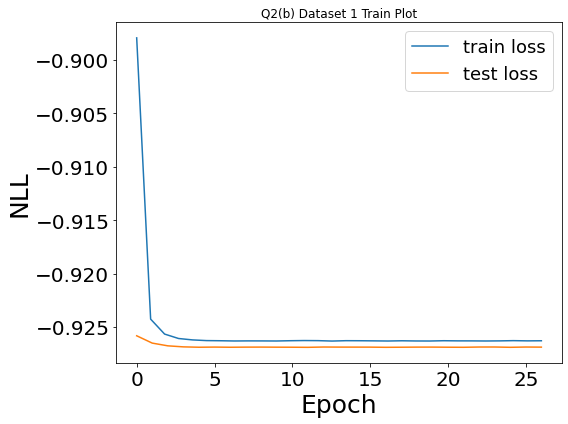

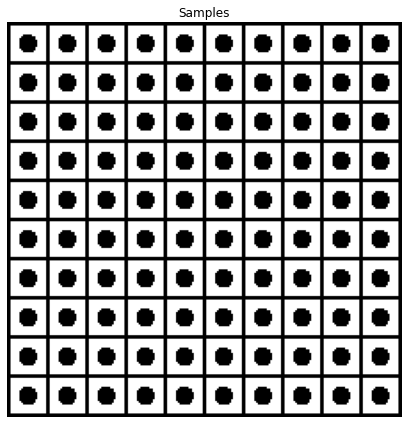

In [ ]:
config_shapes = {"num_layers": 5,
                "num_dim_values": 400,
                "hidden_size": [128, 32, 128],
                "batch_size": 50, 
                "epochs": 30,
                "validate_each_n_epoch": 10,
                "dataset_number": 1,
                "lr": 0.01,
                "beta1": 0.5,
                "beta2": 0.99, 
                "d": 20}
made = MADE2(**config_shapes)
q1_save_results(1, 'b', made.train_loop, DRIVE_DATA_PATH)

In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.1911


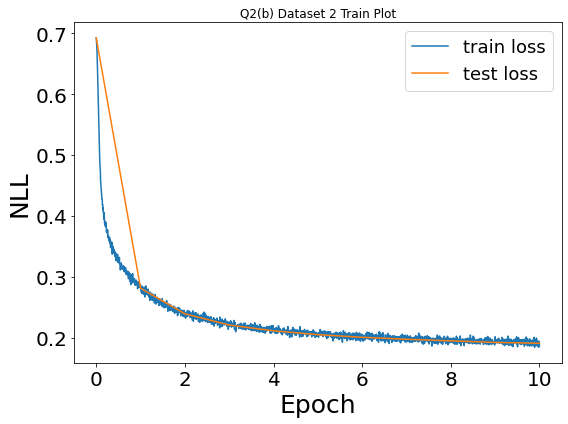

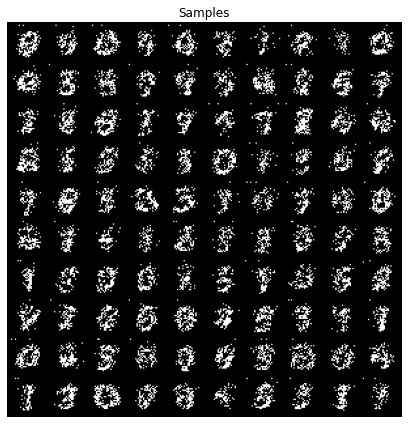

In [ ]:
q1_save_results(2, 'b', q1_b)